>## research paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

In [1]:
import torch
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print(f"helper_functions.py already exists, skipping download...")
else:
    print(f"downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)

helper_functions.py already exists, skipping download...


In [3]:
import helper_functions

image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                               destination="pizza_steak_sushi",
                               remove_source=True)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [5]:
!git clone https://github.com/stanleyedward/pytorch_modules.git

fatal: destination path 'pytorch_modules' already exists and is not an empty directory.


In [6]:
from pytorch_modules.modules import data_preprocess
from torchvision import transforms
#create image size( table 3 of vit paper)
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])
print(f"manually creaated transforms: {manual_transforms}")

manually creaated transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
#craete a batchsize of 32 (even tho paper uses 4096 we dont have hardware for it)
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_preprocess.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
### visualize a single image
#get a batch of imge
image_batch, label_batch = next(iter(train_dataloader))
#get a single img and abel form the batch
image, label = image_batch[0], label_batch[0]

#view the abtch shapes
print(f"train_dataloader_batchshape: {image_batch.shape}")

#view the single img shape
image.shape, label

train_dataloader_batchshape: torch.Size([32, 3, 224, 224])


(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

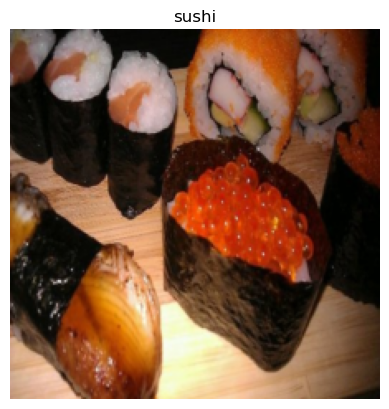

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) #as matplotlib takes CHW
plt.title(class_names[label])
plt.axis("off")

# overview of the paper
- figure 1: viual overview of the architecture
- four equations: math equations which define the function ofeach layer/block
- table 1/3: diffrente hyperparamters for the architecture/trianing.
- text

### figure 1
![Alt text](image-2.png)
* embedding - learnable representation (start with random numbers and improve them overtime) 
* mlp = multilevel perceptron



### four equations
![Alt text](image-1.png)

Equaion1:
* embedding - learnable representation (start with random numbers and improve them overtime) 
* path embeddings - patches of original image - pink
* position embeddings - to retain positional information -  purple
* class token embedding - to perform classification (*/pink)

```python
x_input = [learnable_class_token, image_patch_embeddings_1, image_patch_embeddings_2,...image_patch_embeddings_N]+
            [learnable_class_token_pos, image_patch_1_embeddings_pos, image_patch_2_embeddings_pos,...image_patch_N_embeddings_pos]
```

Equation2:
* MSA = Multi-Head self attention (Multi-Head Attension)
* LN = LayerNorm (Norm))
* zv(l-1) = input before LN block, adding residual connections (+)

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input 

```

Equation3:
* MLP = MultiLayer Perceptron
* LN = LayerNorm
* z'v(l) = input before LN block, adding residual connections (+)

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Equation4:
* MLP = MultiLayer Perceptron - a nerual network with x no. of layers
* MLP = one hidden layer at training time
* MLP = single linear layer in fine-tuning time
* LN = LayerNorm

```python
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```
or
```python
y = MLP(LN_layer(x_output_MLP_block)) 
```


### table 1/3:
![Alt text](image-3.png)

#### all different sizes of the same model
#### ViT-B/16 - ViT-Base with image patch size 16x16

* layers = no. of transformers encoder layers
* hidden size $D$  - the embedding size throughout the architecture

                    - if we have embedding size of 768 means 

                    - each image patch that may be 16x16 

                    - is turned into a vector of size 768

                    - learnable vector*
                    
* MLP size - no. of hidden units/neurons in the MLP

            - if the MLP size is 3072 
            - then the no of hidden units in the MLP layer in 3072

* Heads - the number of heads within multihead self-attention layers

        - if heads = 12 we have 12 heads in MSA layer
        
> ![Alt text](image-4.png)
        
        - denoted by h



### text

>## Equation 1: split data into patches and creating the class, position and patch embedding 

### layers = input -> function -> output 

* what's the input shape?
* whats the output shape?

one of the biggest porblems in dl are misaligned tensor shapes

* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: 

* Input shape: $H*W*C$ [hieight,width, color channels]
* output shape: $N\times(P^2*C)$
- H = height
- W = width
- C = Color channels
- P = patchs ize
- N = number of patches = (height*width)/p^2
- D =  constant latent vector size = embedding dimension (see table 1)

In [10]:
# exmaple values 
height = 224
width = 224
color_channels = 3
patch_size = 16

#calc the number of patches
num_patches = int((height *width) / (patch_size**2)) 
num_patches

196

In [11]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#otput shape
embedding_layer_output_shape = (num_patches, patch_size**2 * color_channels)

print(f"input shape( single@D iamge): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of pathces): {embedding_layer_output_shape}")

input shape( single@D iamge): (224, 224, 3)
Output shape (single 1D sequence of pathces): (196, 768)


* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: (196,768) -> (number of patches, embedding_dimension)   ; embedding dimension = $D$ from table 1

## turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

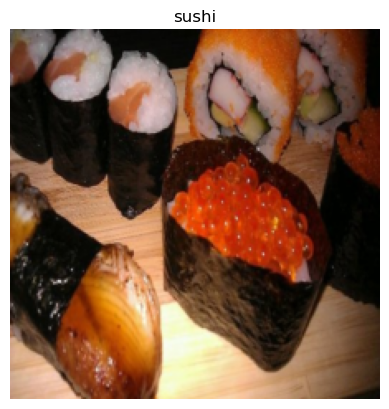

In [12]:
#view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")

In [13]:
image.shape

torch.Size([3, 224, 224])

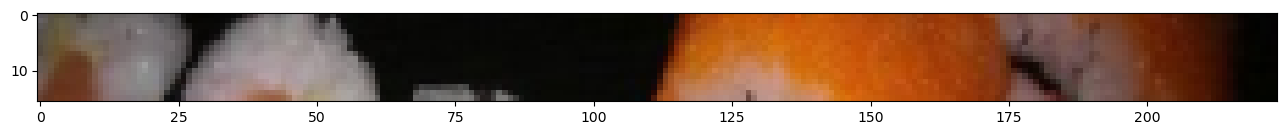

In [14]:
#get the top row of the image
image_permuted = image.permute(1,2,0) #HWC for matplotlib

#index to plot the top row of pixels
patch_size = 16 #from paper
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
 Patch size:16 x 16 pixels
0 0
1 16
2 32
3 48
4 64
5 80
6 96
7 112
8 128
9 144
10 160
11 176
12 192
13 208


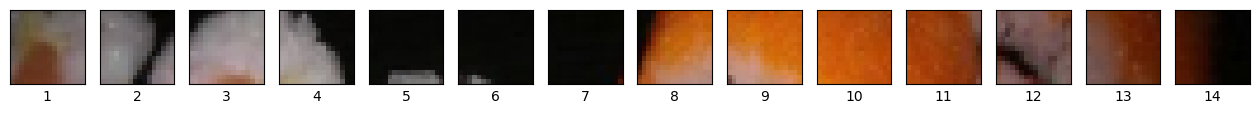

In [15]:
#setup code t oplot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisble by patch size"
print(f"Number of patches per row: {num_patches}\n Patch size:{patch_size} x {patch_size} pixels")
#create a series of subplots
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size// patch_size, #one column for each patch
                         sharex=True,
                         sharey=True,
                         figsize = (patch_size,patch_size)
)

#iterate thorugh the patches in the top row 
for i, patch in enumerate(range(0,img_size, patch_size)): #from 0 to img_size with step of patchsize 
    print(i,patch)
    axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])
    

Number of parches per row: 14.0    
Number of patches per column: 14.0        
Patch size: 16 x 16 pixels


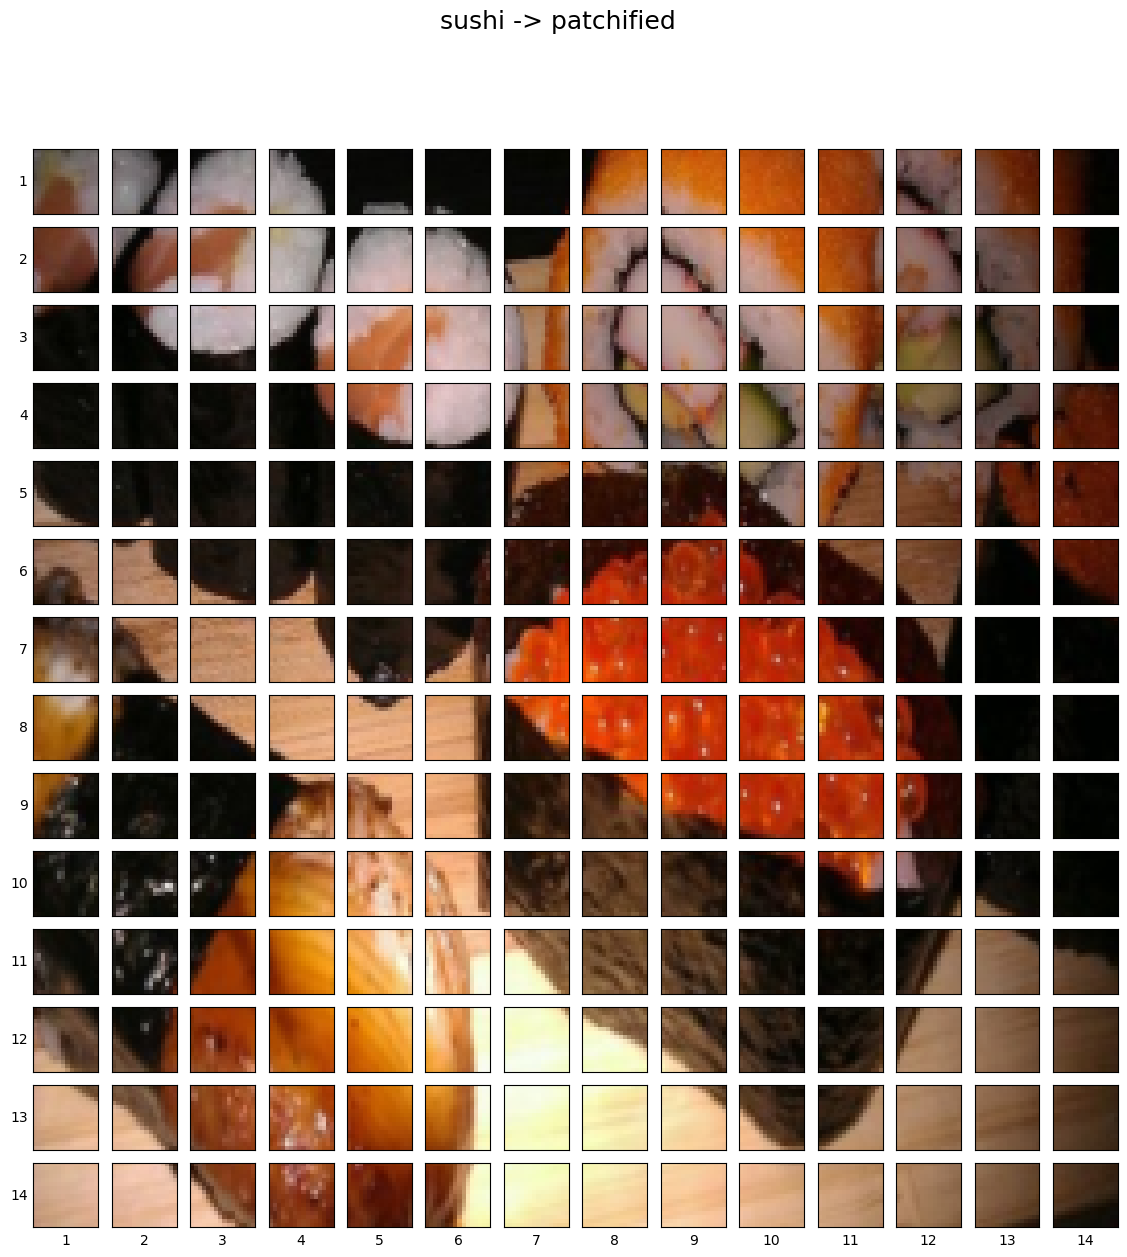

In [16]:
#plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisble by patch size"
print(f"Number of parches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
        \nPatch size: {patch_size} x {patch_size} pixels")

# craete a series of subplots 
fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(num_patches,num_patches),
                         sharex=True,
                         sharey=True)

#loop thuough the height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        #plot the permuted img o n the diffrent axes
            # print(i,j,patch_height, patch_width)
            axis[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #iterate through height
                                             patch_width:patch_width+patch_size, #iterante though width
                                             :])#get all color channels
            axis[i, j].set_ylabel(i+1,
                                  rotation="horizontal",
                                  horizontalalignment="right",
                                  verticalalignment="center")
            axis[i, j].set_xlabel(j+1)
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])
            axis[i ,j].label_outer()
#set up the title fo rth plot
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=18)
plt.show()

In [17]:
14*14 #patches

196

## creating image patches and turning them into patch embeddings

* perhaps we could create the image patches and imge patch embedding ina  single step using 
`torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`.
- a convolutinal feature map is a laernable representation or `an embedding`

In [18]:
#create conv2d layer to turn image into patches of learnable feature mas (embeddings))
from torch import nn
#set the patchpisze
patch_size = 16
#create a conv2d layers with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, #D size from table 1 for ViT-Base, embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

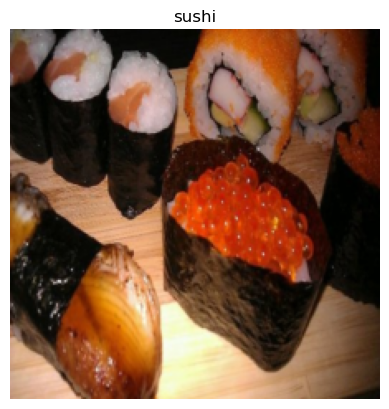

In [19]:
#view single image
plt.title(class_names[label])
plt.imshow(image.permute(1,2,0))
plt.axis(False)

In [20]:
#paass the image thorugh the conv layer
image_out_of_conv = conv2d(image.unsqueeze(0)) #batchdimension  -> [batchsize, color channels, hieght, width]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [21]:
14*14 #number of patchsizes WE NEED TO FLATTEN

196

Now we've passed a single image into our conv2d layers we got 
```python
torch.Size([1, 768, 14, 14]) # [batchsize, embedding_dim, feature_map_height, feature_map_width]
```

In [22]:
image_out_of_conv

tensor([[[[ 0.2247,  0.0833,  0.3797,  ...,  0.1442,  0.1314,  0.0387],
          [ 0.1704,  0.2477,  0.3729,  ...,  0.1880,  0.2081,  0.0189],
          [ 0.0132,  0.2035,  0.2226,  ...,  0.2138,  0.1475,  0.0108],
          ...,
          [ 0.1606,  0.1129,  0.2640,  ...,  0.3779,  0.1810,  0.1057],
          [ 0.3093,  0.1640,  0.2241,  ...,  0.2492,  0.1878,  0.1063],
          [ 0.4258,  0.4260,  0.1990,  ...,  0.2672,  0.1359,  0.0503]],

         [[-0.4286, -0.4479, -0.8152,  ..., -0.3742, -0.4129, -0.0198],
          [-0.3271, -0.4098, -0.7348,  ..., -0.5050, -0.4589, -0.0227],
          [-0.1011, -0.3120, -0.6860,  ..., -0.4254, -0.3569, -0.1052],
          ...,
          [-0.5182, -0.2474, -0.4315,  ..., -0.6707, -0.5736, -0.3211],
          [-1.0015, -0.8316, -0.4956,  ..., -0.7080, -0.4879, -0.3074],
          [-0.9948, -1.0936, -0.7774,  ..., -0.6912, -0.4518, -0.2170]],

         [[-0.1802, -0.2221, -0.1287,  ..., -0.1363, -0.0927, -0.0756],
          [-0.0612, -0.2300, -

In [23]:
image_out_of_conv.requires_grad

True

showing random convolutional feature maps from indexes: [683, 599, 74, 343, 635]


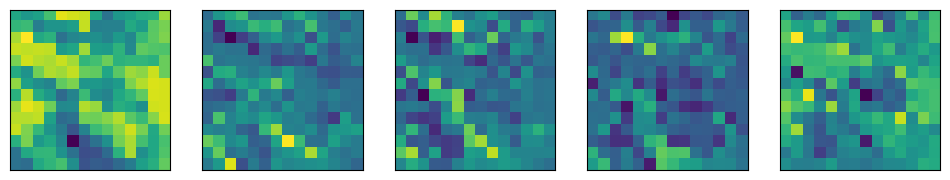

In [24]:
#plot random conv feature maps (embeddings)
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"showing random convolutional feature maps from indexes: {random_indexes}")

# cretea a plot
fig, axis = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12,12)
)

#plot rnadom image feature maps
for i, index in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, index, :, :]# index on the output tensor of the conv2d layer
    axis[i].imshow(image_conv_feature_map.squeeze().detach().numpy())#remove batch dim #remove from grad tracking/ switch to numpy for matplotlib
    axis[i].set(
        xticklabels=[],
        yticklabels=[],
        xticks=[],
        yticks=[]
    )

In [25]:
#get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad, single_feature_map.shape


(tensor([[[0.2247, 0.0833, 0.3797, 0.0951, 0.1502, 0.0176, 0.0312, 0.3464,
           0.2943, 0.2812, 0.2821, 0.1442, 0.1314, 0.0387],
          [0.1704, 0.2477, 0.3729, 0.2778, 0.4543, 0.1466, 0.1868, 0.4113,
           0.4032, 0.2739, 0.2434, 0.1880, 0.2081, 0.0189],
          [0.0132, 0.2035, 0.2226, 0.1773, 0.3791, 0.4799, 0.2304, 0.2623,
           0.2752, 0.3045, 0.2196, 0.2138, 0.1475, 0.0108],
          [0.0263, 0.0223, 0.0595, 0.0608, 0.2844, 0.3887, 0.2936, 0.3388,
           0.3371, 0.1891, 0.1016, 0.2667, 0.1126, 0.1326],
          [0.0705, 0.0697, 0.0511, 0.0136, 0.0469, 0.0230, 0.2650, 0.2244,
           0.2520, 0.2401, 0.2290, 0.2238, 0.1314, 0.1721],
          [0.3189, 0.2709, 0.1089, 0.0852, 0.0833, 0.0436, 0.1414, 0.1717,
           0.2898, 0.1547, 0.1893, 0.2017, 0.0207, 0.1171],
          [0.3180, 0.2826, 0.3941, 0.2980, 0.0464, 0.2381, 0.1836, 0.3976,
           0.3349, 0.3255, 0.1869, 0.1142, 0.0156, 0.0133],
          [0.2623, 0.0040, 0.2698, 0.4525, 0.3398, 0.23

## flattening the patch embedding/ feature map with torch.nn.flatten
right now we've got a series of conv faeture maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satusfy the criteria of the
ViT 

In [26]:

print(f"{image_out_of_conv.shape} -> [batch_size, embeddingdim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embeddingdim, feature_map_height, feature_map_width]


### went [batch_size, num_of_patches, embeddingdim]

In [27]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, 
                           end_dim=3)
flatten_layer(image_out_of_conv).shape #the order is still not w

torch.Size([1, 768, 196])

### order is still not correct

Originval image shape: torch.Size([3, 224, 224])
image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape : torch.Size([1, 768, 196])


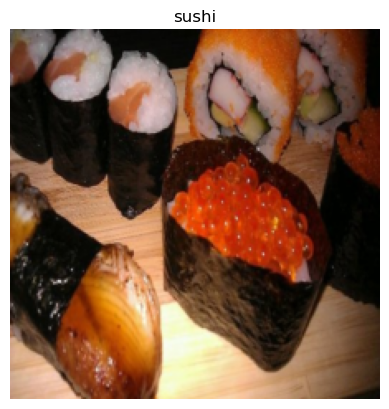

In [28]:
#put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Originval image shape: {image.shape}")

#turn image into faeture maps
image_out_of_conv = conv2d(image.unsqueeze(0))#add batch dim
print(f"image feature map (patches) shape: {image_out_of_conv.shape}")

#flatten the faeture maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape : {image_out_of_conv_flattened.shape}")

In [29]:
#rearrage output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> [batchsize, num of patches, embedding dimension]")

torch.Size([1, 196, 768]) -> [batchsize, num of patches, embedding dimension]


In [30]:
#get a single flattened feature map 
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map, single_flattened_feature_map.shape

(tensor([[0.2247, 0.0833, 0.3797, 0.0951, 0.1502, 0.0176, 0.0312, 0.3464, 0.2943,
          0.2812, 0.2821, 0.1442, 0.1314, 0.0387, 0.1704, 0.2477, 0.3729, 0.2778,
          0.4543, 0.1466, 0.1868, 0.4113, 0.4032, 0.2739, 0.2434, 0.1880, 0.2081,
          0.0189, 0.0132, 0.2035, 0.2226, 0.1773, 0.3791, 0.4799, 0.2304, 0.2623,
          0.2752, 0.3045, 0.2196, 0.2138, 0.1475, 0.0108, 0.0263, 0.0223, 0.0595,
          0.0608, 0.2844, 0.3887, 0.2936, 0.3388, 0.3371, 0.1891, 0.1016, 0.2667,
          0.1126, 0.1326, 0.0705, 0.0697, 0.0511, 0.0136, 0.0469, 0.0230, 0.2650,
          0.2244, 0.2520, 0.2401, 0.2290, 0.2238, 0.1314, 0.1721, 0.3189, 0.2709,
          0.1089, 0.0852, 0.0833, 0.0436, 0.1414, 0.1717, 0.2898, 0.1547, 0.1893,
          0.2017, 0.0207, 0.1171, 0.3180, 0.2826, 0.3941, 0.2980, 0.0464, 0.2381,
          0.1836, 0.3976, 0.3349, 0.3255, 0.1869, 0.1142, 0.0156, 0.0133, 0.2623,
          0.0040, 0.2698, 0.4525, 0.3398, 0.2358, 0.2316, 0.2973, 0.2676, 0.3461,
          0.2592

## ^embedding vector that one of our images is represented by, 768 of these flattened vectors
## these are learnable ie they are update upon training

(-0.5, 195.5, 0.5, -0.5)

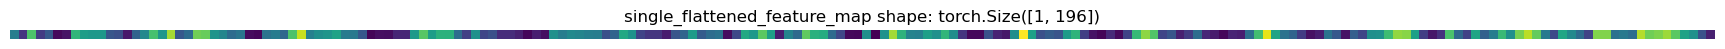

In [31]:
#plot the flattened feature map visually 
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"single_flattened_feature_map shape: {single_flattened_feature_map.shape}")
plt.axis("off")

## Turning the ViT patch embedding layer into a pytorch modeule
we want this module to do a few things.
1. Create a class called PatchEmbedding that inherits from nn.Module
2. Initialize with appropriate hyperparameters, such a schannels, embedding dimension, patch_size.
3. create a layer to turn an imamge into embedded patches using nn.Conv@d().
4. create a layer to flatten the feautre maps of the output of the layer in 3.
5. define forward() that defines the forward computations (eg. pass through layer from 3 to 4)
6. make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [32]:
#1. create a class called Patchembedding
class PatchEmbedding(nn.Module):
    #2. initialize the layer owth appropriate hyperparamters
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768): #from table 1 for ViT_base
        super().__init__()
        self.patch_size = patch_size
        #3. creata a layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        #4. create a layer to flatten feature maps outputs of conv2d
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        #creata assertion to mkae sure the image resolution is compatable with the patch size
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patchsize, image shape: {image_resolution}, patch_size = {self.patch_size}"
        
        #perfrm forawrd pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        #6. make sure thereturned sequence embeddign dim are in the righ torder [batchsize,no of patches, embdedding dim]
        return x_flattened.permute(0,2,1)
    

In [33]:

#ccreate an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# pass a single image thorugh the patch embedding layer
print(f"input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batchdim
print(f"output patch embedding sequence shape: {patch_embedded_image.shape}")


input image size: torch.Size([1, 3, 224, 224])
output patch embedding sequence shape: torch.Size([1, 196, 768])


In [34]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad =torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor_bad) 

AssertionError: Input image size must be divisible by patchsize, image shape: 250, patch_size = 16

### we get an error as we made an assertion to make sure our input image is compatible iwth our patch_size

## creating the class token embedding 
* want to prepend a learnable class token to the start of the patch embedding
* in order to perform classificaiton we use the standard approach of adding an extra learnable classification token 

In [35]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

after we prepend the class token it should become [1,197, 768]

In [36]:
#get the batchsize and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [37]:
#create class token embedding as a laernable paramter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)  # to make the paramter learnable its on by default
class_token.shape

torch.Size([1, 1, 768])

### USING ONES TO MAKE IT MORE VISIBLE for learning
### NOTe: use randn in practical use

In [38]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [39]:
#add the class token embedding to the from of the patch embedding # From the paper
patch_embedded_image_with_class_embedding= torch.cat((class_token, patch_embedded_image),
                                                     dim=1) #no of patches dim 
print(f"{patch_embedded_image_with_class_embedding.shape} -> batch_size, class_token + no_of_patches, embedding_dim")

torch.Size([1, 197, 768]) -> batch_size, class_token + no_of_patches, embedding_dim


In [40]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2044,  0.1213, -0.3727,  ..., -0.0422, -0.1065, -0.1086],
         [-0.1035, -0.0072, -0.4738,  ..., -0.0445, -0.1931,  0.1067],
         ...,
         [-0.2448,  0.0557, -0.5102,  ..., -0.0727, -0.2336, -0.0618],
         [-0.1278,  0.0315, -0.3228,  ..., -0.0731, -0.1883, -0.0347],
         [-0.0428,  0.0037, -0.1469,  ..., -0.0665, -0.0937, -0.0178]]],
       grad_fn=<CatBackward0>)

## creating the position embedding

want to: create a series of 1d learnable positionembedding and to add them to the sequence of patch embeddings

In [41]:
#view the sequence of patch embeddinigs withthe prepended class embeddings
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2044,  0.1213, -0.3727,  ..., -0.0422, -0.1065, -0.1086],
          [-0.1035, -0.0072, -0.4738,  ..., -0.0445, -0.1931,  0.1067],
          ...,
          [-0.2448,  0.0557, -0.5102,  ..., -0.0727, -0.2336, -0.0618],
          [-0.1278,  0.0315, -0.3228,  ..., -0.0731, -0.1883, -0.0347],
          [-0.0428,  0.0037, -0.1469,  ..., -0.0665, -0.0937, -0.0178]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [42]:
#calculate the N no of  patches
num_patches = int((height * width) / patch_size**2)
#get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension

#create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(batch_size, #batchsize or 1
                                             num_patches+1, #from paper # and as we added the class token  we get 197 instead of 196
                                             embedding_dimension),
                                  requires_grad=True) #learnable so it gets updated during training
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

Add the position embedding to the patch and class token embeddding

In [43]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2044,  0.1213, -0.3727,  ..., -0.0422, -0.1065, -0.1086],
          [-0.1035, -0.0072, -0.4738,  ..., -0.0445, -0.1931,  0.1067],
          ...,
          [-0.2448,  0.0557, -0.5102,  ..., -0.0727, -0.2336, -0.0618],
          [-0.1278,  0.0315, -0.3228,  ..., -0.0731, -0.1883, -0.0347],
          [-0.0428,  0.0037, -0.1469,  ..., -0.0665, -0.0937, -0.0178]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [44]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape
# print(patch_and_position_embedding)
# print(f"patch and position embedding shape: {patch_and_position_embedding.shape}")

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7956, 1.1213, 0.6273,  ..., 0.9578, 0.8935, 0.8914],
          [0.8965, 0.9928, 0.5262,  ..., 0.9555, 0.8069, 1.1067],
          ...,
          [0.7552, 1.0557, 0.4898,  ..., 0.9273, 0.7664, 0.9382],
          [0.8722, 1.0315, 0.6772,  ..., 0.9269, 0.8117, 0.9653],
          [0.9572, 1.0037, 0.8531,  ..., 0.9335, 0.9063, 0.9822]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

## as you can see all the values increased by one as we created positional embeddding with `torch.ones`
## successfully added it to the patch_embeddings with class_token

## finally finished equation 1 :D

## PUTTIGN IT ALL TOGETHER (EQ:1) in one cell

>## equation 1
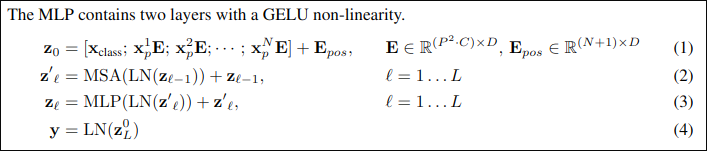

In [45]:
import helper_functions
#set the seeds
helper_functions.set_seeds()

#!set the patch ize: there are multiple patchsizes in the paper we use 16
patch_size = 16

#2. print the sahapes of the original image and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

#3. get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

#4.create a patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768) #inline with ViT-base in table 1
#5. pass input iamge through patchembedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")
#6.creating class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension), #using ones for laerning use randn for practical architecture
                          requires_grad=True)
print(f"class token embedding shape: {class_token.shape}")
#7. prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch_embedding with class token shape :{patch_embedding_class_token.shape}")
#8.create position embedding 
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) #look at paper for plus 1
#9. add the posotion embedding to patch embedding with class otken
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch_and_position_embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
class token embedding shape: torch.Size([1, 1, 768])
patch_embedding with class token shape :torch.Size([1, 197, 768])
patch_and_position_embedding shape: torch.Size([1, 197, 768])


># Equation 2.
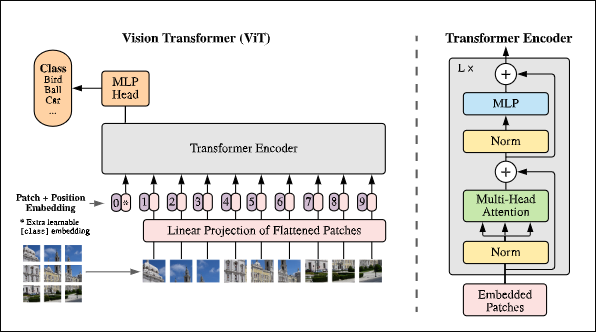

## we finished embedding the patches 
## now we enter the transformer encoder
- consists of 2 main blocks of eq.2 and eq.3

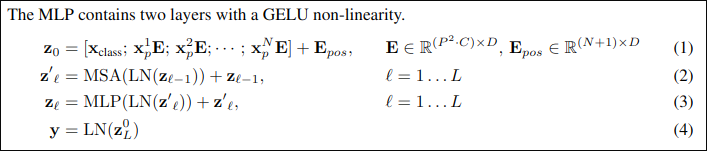
### equation 2 has the MSA block
- for many of these layers like `MSA` pytorch has prebuilt function for the layer

#### from [Attention Is All You Need paper](https://arxiv.org/abs/1706.03762)
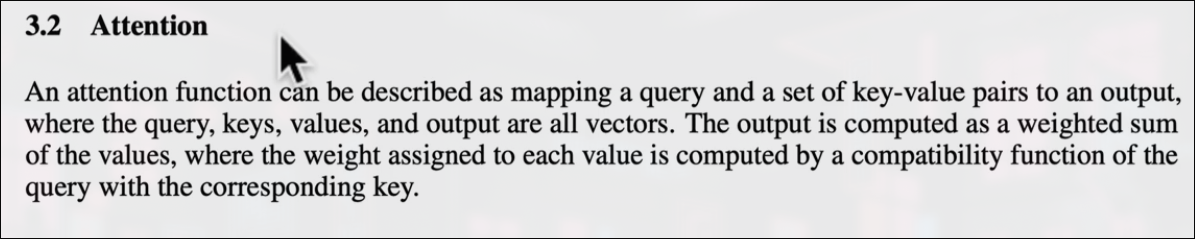

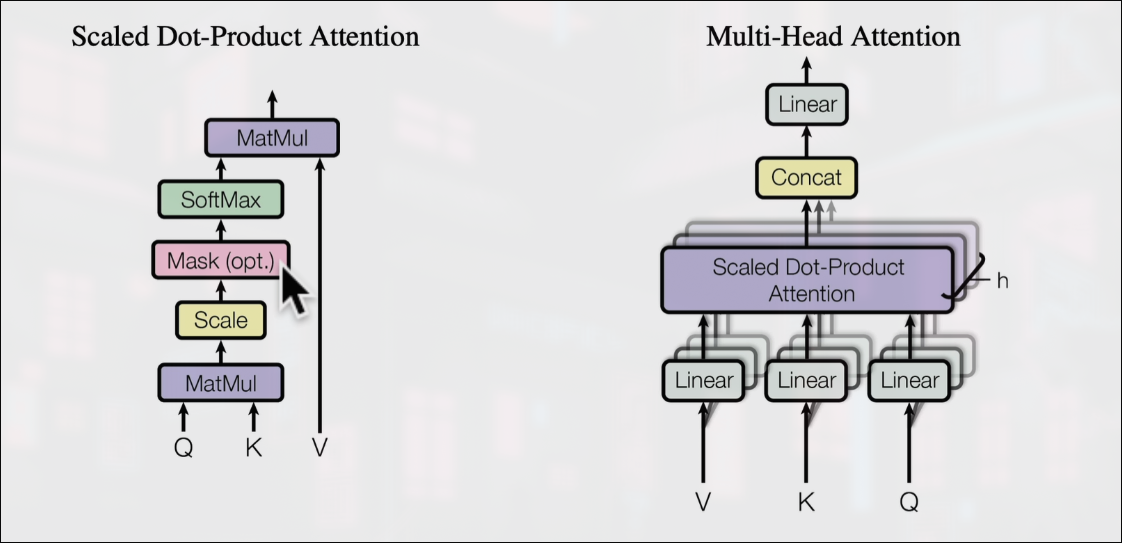

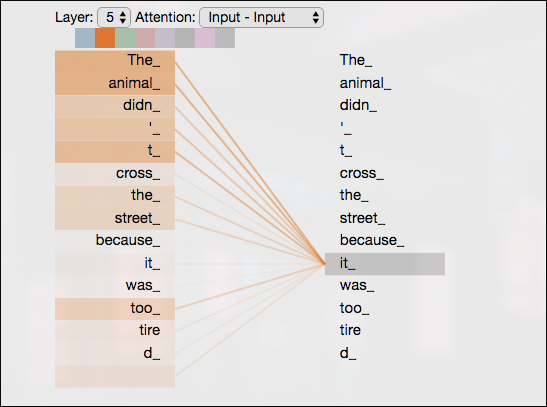

Q- Query, K-key, V-value are instances of the `same` sequence of vectors,

tells us which patch needs to pay how much `attention` to which other word or image patch in the same vector,

to find how much related 1 patch is to another

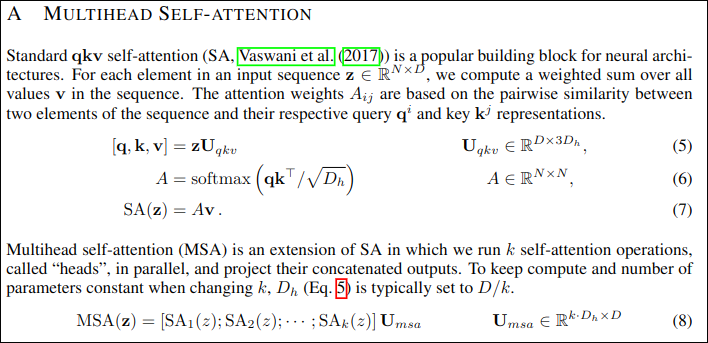

## equation 2 (Multihead self-attention) (msa block)
* MSA: which part of a sequence should pay the most attnetino to itself?
* in our case, we have a series of embedded image atches, which patch significantly relates to another patch.
* we want our nerual network `(ViT)` to learn this relationship/ representation
* to replicate MSA in pytorch use  [pytorch-MSA-doc](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)

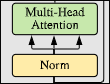 
- as u can see there are 3 arrows from the norm layer entering the MSA block
- these are the instances of the output of the norm layer K,Q,V (Query embeddings, key embeddings, value embeddings) 

## equation 2 (layer normalization) (LN block)
* ### layer norm

            - normalization technique to normalize the distributions of the intermediate layers,
             
            - it enables smoother gradients, faster training, and better generalization accuracy 
- Normalization - make everything have name mean and same std deviation
- mean and std dev are calculated over the last D dimension, where D is the dim of normalized shape

$D$ in our case is the embedding dimensions here [768]

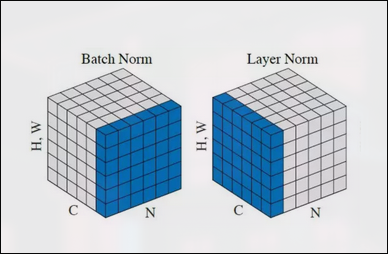
       
        * when we normalize along the embedding dimension, it's like making all of the steps in the staircase to the same size

in docs:
- no of patches = sequence 
- features = embedding dimension

In [46]:
## creating a multihead self attentionlayer in pytorch
class MultiHeadSelfAttentionBlock(nn.Module):
    """creates a multihead self attention block (MSA block)
    """
    def __init__(self,
                 embedding_dimension: int=768, #Hidden size D (embedding dimension) from table 1 for ViT _base
                 num_heads: int=12, #heads from table 1 for ViTbase
                 attn_dropout: int=0):#dropout is only used for dense layer/ fully coneccted/ linaer/ feed forward. but not for QKV projections 
                                        #ie we are not gonna use dropout for our MSA block
        super().__init__()
    #create the norm layer (LN)
        self.layer_norm = nn.LayerNorm( 
            normalized_shape=embedding_dimension#check pytroch docs
        )
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dimension, # hidden size D (embedding dimension) from table 1 for ViT-base
            num_heads=num_heads, #no of MSA heads
            dropout=attn_dropout, #zero
            batch_first=True #batch_first – If True, then the input and output tensors are provided as (batch, no of patches or sequence, features or embedding dimension). Default: False (seq, batch, feature) #from pytorch docs
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # Q,K and V are x: they are different instances of the same vector
        x = self.layer_norm(x)
        attn_output, _ =  self.multihead_attn(query=x,
                                                key=x,
                                                value=x,
                                                need_weights=False)                  # u can also get attn_weights ie weights of the attention layer #check the docs.
        return attn_output

In [47]:
# create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dimension=768,
    num_heads=12,
    attn_dropout=0
)

#pass the patch and position image embedding sequence thourgh our MSA Block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA bock: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block; {patched_image_through_msa_block.shape}")

Input shape of MSA bock: torch.Size([1, 197, 768])
Output shape of MSA block; torch.Size([1, 197, 768])


## even tho the shapes haven't changed maybe the values changed??

In [48]:
#input
patch_and_position_embedding 

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4842, 1.1071, 0.9806,  ..., 1.2911, 0.8060, 1.1216],
         [0.4619, 0.9047, 0.8579,  ..., 1.3663, 0.9612, 1.4155],
         ...,
         [0.4886, 1.0627, 0.8966,  ..., 1.3370, 0.7364, 1.2223],
         [0.6908, 1.0200, 0.9475,  ..., 1.2131, 0.8064, 1.1861],
         [0.8316, 1.0010, 0.9662,  ..., 1.0398, 0.9115, 1.1034]]],
       grad_fn=<AddBackward0>)

In [49]:
#output
patched_image_through_msa_block

tensor([[[-0.1992, -0.1785,  0.0754,  ..., -0.3689,  0.8296, -0.4426],
         [-0.1836, -0.1788,  0.0768,  ..., -0.3568,  0.8418, -0.4648],
         [-0.1715, -0.1662,  0.0784,  ..., -0.3658,  0.8433, -0.4552],
         ...,
         [-0.1745, -0.1771,  0.0726,  ..., -0.3638,  0.8436, -0.4722],
         [-0.1707, -0.1792,  0.0704,  ..., -0.3669,  0.8461, -0.4732],
         [-0.1732, -0.1884,  0.0665,  ..., -0.3622,  0.8442, -0.4701]]],
       grad_fn=<TransposeBackward0>)

In [50]:
patched_image_through_msa_block == patch_and_position_embedding

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

## how do we add the skip/residual connection in this?

>## Equation 3: Multilayer perceptron block (MLP block)
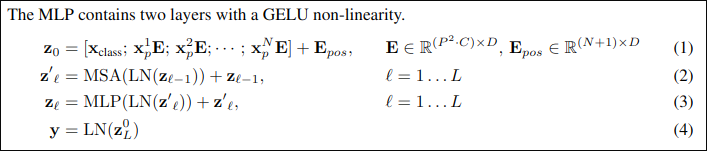

### **MLP** contains two layers with a GELU non-linearlity(mentioned above)

    * MLP = a quite broad term for a block with a series of layer(s), ayers can be multiple or even only one hidden layer.
    * layers can mean: fully connected/ dense/ linear/ feed-forward, all are often similar names for the same thing. 
    In pytorch theyre called `torch.nn.Linear`.
    In tensorflow theyre called `tf.keras.dense
**MLP_size / number of hidden units of MLP** = 3072 for ViT-Base (from table 1)

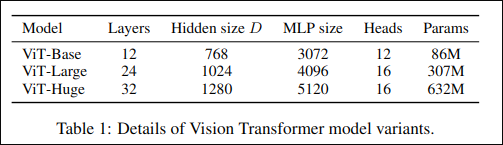

### [what is **GELU** non linearity](https://paperswithcode.com/method/gelu) 
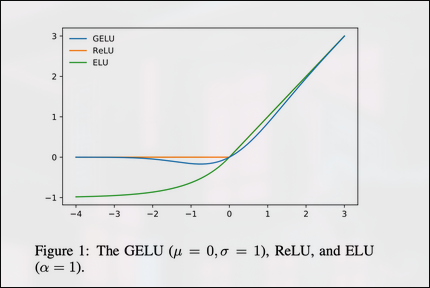

    * the standard Gaussian cumulative distribution function. The GELU nonlinearity weights inputs by their percentile, rather than gates inputs by their sign as in ReLUs (). 
    * Consequently the GELU can be thought of as a smoother ReLU.
    * applies the Gaussin Error Linear Units Functions (GELU)

**Dropout** is applied after every linear layer in MLP

    * value for dropout is available at table 3 Dropout = 0.1 for Vit/b-16

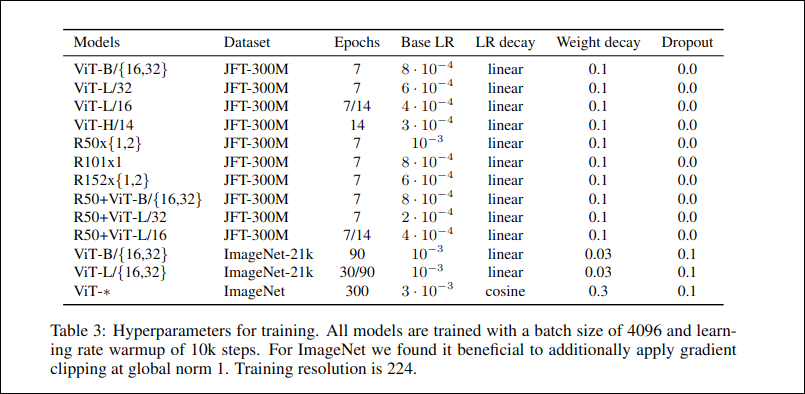

In pseudocode:
```python
#MLP block
x = layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout
```

In [51]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: float=0.1
                 ):
        super().__init__()
        #creat the norm layer (LN)
        self.layer_norm = nn.LayerNorm(
            normalized_shape=embedding_dim
        )
        
        #creat eh MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size), #project to a larger size # to hopfully capture some fore information 
            nn.GELU(),
            nn.Dropout(
                p=dropout
            ),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), #squeeze it back to the embedding dimension 
            nn.Dropout(
                p=dropout
            )
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        #return self.mlp(self.layer_norm(x) #same as above# this will benefit from operator fusion 


### side track:  https://horace.io/brrr_intro.html || checkout torch.compile feature that leverages operator fusion mentioned above


In [52]:
#create an instance of MLP block
mlp_block = MLPBlock(embedding_dim=768, #talble 1 value
                     mlp_size=3072, #table 1 value
                     dropout=0.1) #table 3 value

#pass ouot through the MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of the MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of the  MLP blcok: {patched_image_through_mlp_block.shape}")

Input shape of the MLP block: torch.Size([1, 197, 768])
Output shape of the  MLP blcok: torch.Size([1, 197, 768])


In [53]:
#the variables have changed even though the values are the same
patched_image_through_mlp_block == patched_image_through_msa_block

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

## this is not really the correct order of doing things as we havent added the residual connections yet
## we are just creating modules of the final product

># creating the transformer encoder (with residual connections)
The transfformer encoder is a combination of alternating blocks of MSA blocks and MLP blocks
LN is applied between every block, and residual connections after every block

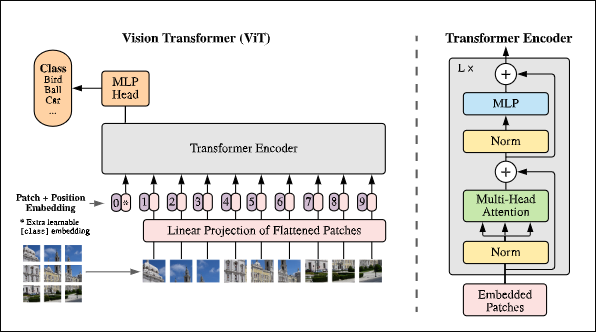

**encoder** = turn a sequence into a laernable representation

**decoder** = turna learnable representation to some sort of sequence

encoders in NLP converts text(sequence) into numbers 
decoders decontructs encoded numbers into text (sequence) (in a translator)

### also known as Seq2Seq
seq2seq is a ml model usually used in NLP. This is also where our transformer came from ie NLP which has `encoders as well as decoders`

thats were our name transformer `encoder` comes from, 
since our goal is image `classification` instead of a decoder we use an `MLP` instead of an `Decoder`

* residual connnections = add alyer(s) input to its subsequent output, 
this enables the creation of deeper networks (prevents weights from getting too small ie preventing `spare networks` or `vanishing gradient problem`)

In pseudo:
```python
#transfomer encoder:
x_input (output/sequence of embedding patches) -> MSA_Block -> [MSA_Block + x_input (residual)] -> MLP_Block -> [MLP_block_output + (MSA_block_output + x_input) ] -> ...
```

>### method 1:coding in the transformer block (puting it all together)

In [54]:
class TransformerEncoderBlock(nn.Module):
    """creates a transformer block instance"""
    def __init__(self,
                 embedding_dim:int=768, # hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dimension=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [55]:
#create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()
transformer_encoder_block

TransformerEncoderBlock(
  (msa_block): MultiHeadSelfAttentionBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLPBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

## get summary of the model using `torchinfo`

In [56]:
rand_tensor = torch.randn(size=(1,197,768))
transformer_encoder_block(rand_tensor).shape


torch.Size([1, 197, 768])

In [57]:
from torchinfo import summary

summary(model=transformer_encoder_block,
        input_size=(1,197,768), #<- the size of the output of the embedded patches and NOT the original image size
        col_names=["input_size", 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']) 

/usr/lib/python3.11/site-packages/torchinfo/torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### as u can see it expands in the MLP layer then compresses back, might be able to identify more features
### this is just one TransformerEncoderBlock the ViT model had multiple.
- ### residual or skip connections : where first introduced in resnet architectures 

## method 2:there is a trick we can do with pytorch to make the implementation even smaller
since how good the transformer arch is, pytorch has implemented ready to use transformer encoder layers
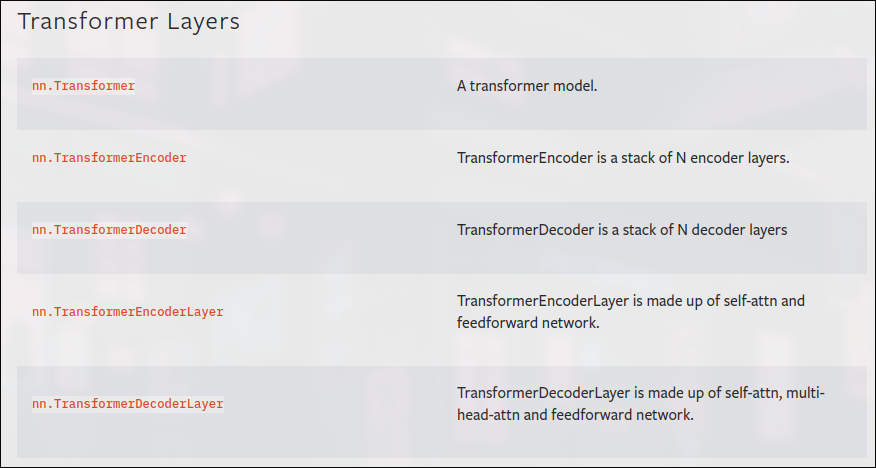

### craete  a tranformer encoder layer with inbuilt pytorch transformer layers

In [58]:
#create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,# embedding dimension/size from table 1
                                                             nhead=12, #no of heads from table 1
                                                             dim_feedforward=3072, # MLP size from table 1
                                                             dropout=0.1, #fro table 3
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True # Layer Norm is First if True, default is false
                                                             )
# this is implementing Eq2 and eq3 at the same time
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [59]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768), #<- the size of the output of the embedded patches and NOT the original image size
        col_names=["input_size", 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']) 

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

The output of the summary is slightly different to ours due to how torch.nn.TransformerEncoderLayer() constructs its layer.

But the layers it uses, number of parameters and input and output shapes are the same.


    Less prone to errors - Generally, if a layer makes it into the PyTorch standard library, its been tested and tried to work.
    Potentially better performance - as of now, the PyTorch implemented version of torch.nn.TransformerEncoderLayer() can see a speedup of more than 2x on many common workloads.
    they generally have a smaller forward/backward pass size

then why did we spend all the time recreating the encoder piece by piece instead of just using the inbuilt function? to know how things work in the background and practise

## if you wanted to stack multiple tranformer encoder layers u can use:

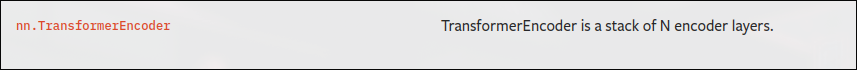
### as u can see in the ViT/B-16 There are 12 layers ( from table 1)
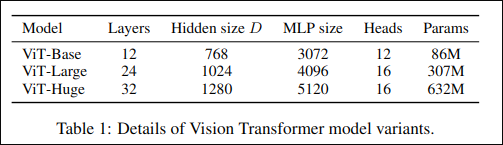

>## putting it all together (along with equation 4)
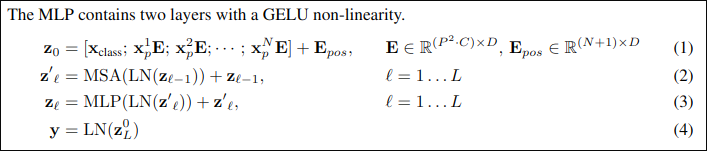

>## ViT architecture.

In [60]:
#create a ViT class
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, #table 3 from the ViT paper
                 in_channels:int=3, #as were dealing with colored images
                 patch_size:int=16,# need patchsze to be compatible with img_size (add assetion)
                 num_transformer_layers:int=12,#heads / transformer layerstable 1 for layers in ViT_base
                 embedding_dimension:int=768, #hidden_size D from table 1 for ViTBase
                 mlp_size:int=3072, #mlp hidden unit size table 1
                 attn_dropout:int=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1, #dropout for patch and position embedddings #check experiment details B.!
                 num_classes:int=1000 #num of classes in our classification problem #set to a 1000 as original ViT was trained on imagenet 
                 ):
        super().__init__()
        
        #make an assertion to check if image size is compatible witht he patchsize
        assert img_size % patch_size == 0, f"Image size must be divisble by patch size, img_size: {img_size}, patch_size {patch_size}"
        
        #calc the no o fpaches (height * width / patch_size **2)
        self.num_patches = (img_size * img_size)// patch_size**2 #HW/PP make sure you have // to floor
        
        #create learnable class embedding #needs to go at front of seqience of patch embeddings
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dimension), #remeber we made it with torch.ones before? now its randn
                                            requires_grad=True) #make it trainable ie update params with optimizer 
        
        #create learning position embedding
        self.position_embeddding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dimension))
        
        #cerae embedding dorpout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        #create create patch_embedding_layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dimension)
        # you can probably modularity this previous block and amke it much easier to create a patch embedding layer
        
        #crete the transformer encoder block
        #to stack 12 of them on top of eaceh oterh in a manual way
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dimension,
                                                                           num_heads=num_transformer_layers,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]) # '*' means all of the layers in this comprehension that gets turned into a sequential block
        
        #create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dimension),
            nn.Linear(in_features=embedding_dimension, #becaus ethe output of the transformerencodinng block is going to have  adim size of embedding dim
                      out_features=num_classes) #since this the final output layer we need out features equal to the number of classes
        )
        
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        #EQUATION 1
        #get the batch)size
        batch_size = x.shape[0] #why hardcore when manipulate the data 
        
        #unlike in the paper we arent using 4096 batch_size because of hardware limitations
        #create class token embedding and expand it to match the batch_size ( equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension #check cell below
        
        #create patch_embedding
        x = self.patch_embedding(x)
        
        #concat class token embedding and patch_embedding
        x = torch.concat((class_token, x), dim=1) #(batchsize, no of patches, embedding_dim)
        
        #add the position embeddding to class token and patch_embedding
        x = self.position_embeddding + x
        
        #Run embedding dropout # when used is applied after every linear layer expect KQV projects /output ie MSA projections
        #and directly after adding positional to patch embeddings: from EXPERMENT DETAILS B.1
        x = self.embedding_dropout(x)
        
        #EQUATION 2 AND 3
        #pass our position and patch_embedding into our transformer encoder 
        x = self.transformer_encoder(x)
        
        #EQUATION 4
        #put 0th index logit through the classifier 
        x = self.classifier(x[:, 0]) # every batch, and the zeroth index 
        
        return x

In [61]:
batch_size = 32
embedding_dimension = 768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dimension), #remeber we made it with torch.ones before? now its randn
                                            requires_grad=True) #make it trainable ie update params with optimizer 
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1) #"-1"  means to infer the dimensions
class_embedding.shape, class_embedding_expanded.shape
#we've expanded thhe class_token embedding across every image in a batch

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

## in equation 4 
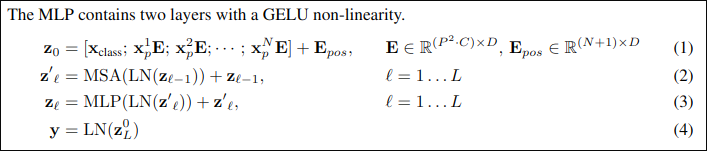
## u can see we only want to pass the classification token as it says (z^0 L) [z zeroth of the last token]
this is why the figure has an arrow only on the last token here at the classification token, ie we only want to pass the classicatino token into the MLP head
- "the classficaiton head is implemeneted by a MLP iwth one hidden layer at pre-training time and by a single linear layer at fine-tuning time"

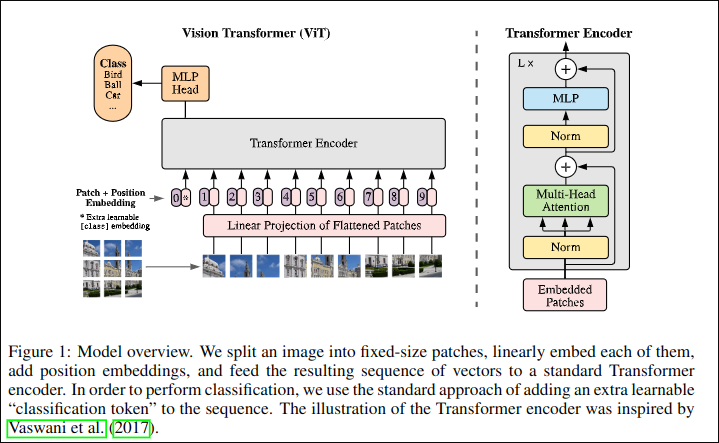

## oddly enough the equation 4 doesnt mention an MLP layer, but the presence of an MLP layer at the end is implied throughout the paper

>## instantiating the ViT class

In [72]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

beautiful.

In [63]:
helper_functions.set_seeds()

#create a random image tensor with same shape as asingle image
random_image_tensor = torch.randn(size=(1,3,224,224))

#create a instace of ViT with the no of class we're working with (pizza, steak and sushi) ie 3
vit = ViT(num_classes=len(class_names))

#pass the random tensor though our vit instance
vit_output = vit(random_image_tensor)
vit_output, vit_output.shape

(tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 3]))

#### we get only 3 classes as expected

### getting a visual summary of our model

In [64]:
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1,3, 224, 224), #<- [B,C,H,W]
        col_names=["input_size", 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## lets see if it actually works
>## Train the ViT model.
Now that we've replicated the architecture, lets see how it perofmrs on our data

### setting up optimizer
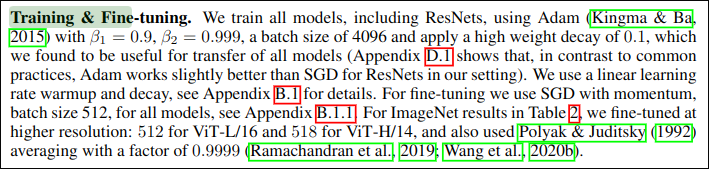
- adam optimizer
 * beta1 = 0.9; beta2 = 0.999 (defaults)
 * weight_decay = 0.1 (high)
    weight decay is L2 regularization method by addning a small penalty, usually the square of the weights, (all the weights of the model), to the loss function, therefore larger weights are penalized more than smaller weights, preventing sparse networks caused in L1 regularization where the absolute sum of the weights are added to the loss, which makes weights tend to 0.0 making it sparse.
    Regularization prevents overfitting.
 * base learning rate = $10^-3$ from table 3

In [65]:
#optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             betas=(0.9,0.999),
                             lr=1e-3) #from table 3


### estting up a loss function
the vit paper doesnt mention what loss function they used.
therefore since it is a multi-clas classification we'll use `nn.crossentropyloss`

In [66]:
# loss
loss_fn = nn.CrossEntropyLoss()

### training our model

In [73]:
from pytorch_modules.modules import train_engine
results = train_engine.train(model=vit,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=10,
                             device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [74]:
import test1
results = test1.train(model=vit,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=10,
                             device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

: 

: 

| **Hyperparameter value** | **ViT Paper** | **Our implementation** |
| ----- | ----- | ----- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 | 
| Batch size | 4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None | 
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None | 
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |